# Project : PySpark Weather Analytics!
------------------------------------------------

The purpose of this project is to master :
* blending Python and SQL
* using pandas UDFs
* writing window functions

# Install Spark

In [ ]:
!pip install pyspark

## Start a Spark Session

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("Project2")\
        .getOrCreate()

In [ ]:
# some useful functions
import pyspark.sql.functions as F
import pyspark.sql.types as T

# Read the Data
We will use the GSOD dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# mount your Drive and update your Path
myDir = '/content/drive/MyDrive/Uconn drive files/Takeout/Drive/Sem-2/BDACC/Module 3/'
gsod = spark.read.parquet(myDir + 'gsod')

In [ ]:
# rows and columns
# 12M rows and 32 columns
print(f"Number of rows and columns : {((gsod.count(), len(gsod.columns)))}")

Number of rows and columns : (12460217, 32)


In [ ]:
# schema
gsod.printSchema()

root
 |-- stn: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- year: string (nullable = true)
 |-- mo: string (nullable = true)
 |-- da: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: long (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: long (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: long (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: long (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: long (nullable = true)
 |-- wdsp: string (nullable = true)
 |-- count_wdsp: string (nullable = true)
 |-- mxpsd: string (nullable = true)
 |-- gust: double (nullable = true)
 |-- max: double (nullable = true)
 |-- flag_max: string (nullable = true)
 |-- min: double (nullable = true)
 |-- flag_min: string (nullable = true)
 |-- prcp: double (nullable = true)
 |-- flag_prcp: string (nullable = true)
 |-- sndp: double (nullable = true)
 |-- fog: string (nullable =

In [ ]:
# look at the first few rows
gsod.show(10, truncate=False)

+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|stn   |wban |year|mo |da |temp|count_temp|dewp  |count_dewp|slp   |count_slp|stp   |count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd|gust |max |flag_max|min |flag_min|prcp|flag_prcp|sndp |fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|917350|99999|2018|04 |21 |82.6|9         |9999.9|0         |1006.9|9        |993.2 |9        |999.9|0          |3.7 |9         |8.5  |999.9|85.5|*       |74.5|        |0.31|G        |999.9|0  |0           |0               

# 🔵 Blending Python and SQL

### Select all rows where `temp` is greater than 90 and where windspeed is greater than 20.

In [ ]:
# cast the windspeed to double type since it is a string
gsod = gsod.withColumn('wdsp',F.col('wdsp').cast(T.DoubleType()))

In [ ]:
# check the schema again to confirm the datatype of windspeed
gsod.select('wdsp').printSchema()

root
 |-- wdsp: double (nullable = true)



In [ ]:
# create a view before using SQL
gsod.createOrReplaceTempView('gsod_view')

In [ ]:
# select the rows where temp>90 and windspeed>20
gsod_tw = spark.sql(
    '''SELECT *
    FROM gsod_view
    WHERE temp > 90
    AND wdsp > 20'''
)

### Print the count of rows and show first 10 rows to confirm your answer.

In [ ]:
# count of rows and columns selected
print(f"Number of rows and columns : {((gsod_tw.count(),len(gsod_tw.columns)))}")

Number of rows and columns : (3867, 32)


In [ ]:
# display the result
gsod_tw.select('temp','wdsp').show(10)

+----+-----+
|temp| wdsp|
+----+-----+
|90.3|999.9|
|91.9| 21.6|
|93.2|999.9|
|99.6|999.9|
|90.2|999.9|
|91.1|999.9|
|92.4|999.9|
|93.3|999.9|
|91.3|999.9|
|91.5|999.9|
+----+-----+
only showing top 10 rows



### How many unique stations met the condition of temp>90 and wdsp>20?

In [ ]:
# create a view before using SQL
gsod_tw.createOrReplaceTempView('gsod_tw')

In [ ]:
# select the unique stations that met the condition temp>90 and windspeed>20
gsod_unique_tw = spark.sql(
    '''SELECT DISTINCT stn
    FROM gsod_tw'''
)

In [ ]:
# count of unique stations that met the condition
print(gsod_unique_tw.count())

297


### Find the top 10 stations (`stn`) where the condition is true.

In [ ]:
# select top 10 stations where temp>90 & windspeed>20 based on count of observations per station. ignore 999999 station
gsod_top10 = spark.sql(
    '''SELECT stn,count(*) count
    FROM gsod_tw
    WHERE stn != 999999
    GROUP BY stn
    ORDER BY count DESC'''
)


In [ ]:
# display the result
gsod_top10.show(10)

+------+-----+
|   stn|count|
+------+-----+
|406370|  294|
|406570|  186|
|408290|  127|
|406320|  118|
|406560|   99|
|406460|   85|
|406080|   84|
|406640|   73|
|406720|   70|
|406660|   54|
+------+-----+
only showing top 10 rows



### Where is the top station (that is not 999999)?
Below is the list of all GSOD stations - we'll Google the location and know where it is and include a picture!

Here is a list of all the GSOD stations:
* http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.GSOD/.MONTHLY/.Name/IWMO+exch+table-+text+text+skipanyNaN+-table+.html

**Answer:** '406370' is the station 'KHANAQIN' - It is hot and windy there!



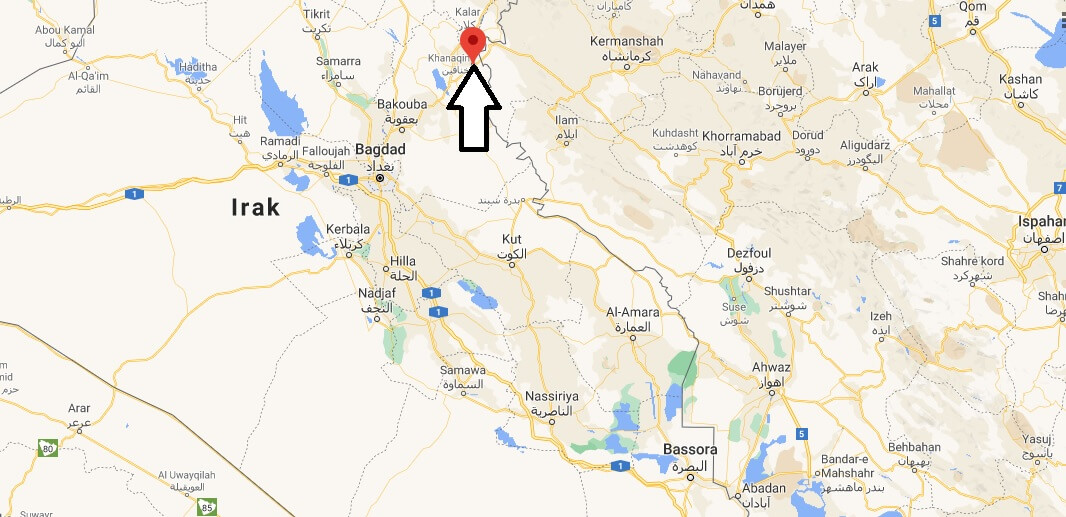



### What month/year was the hottest and windiest at that particular station?

In [ ]:
# hottest month/year at Khanaqin

# select the first temp value after arranging temp values in descending order
khanaqin_hot_year = spark.sql(
    '''
    SELECT stn,year,mo,da,temp
    FROM gsod_tw
    WHERE stn == 406370
    ORDER BY temp DESC
    LIMIT 1'''
)

# display the result
khanaqin_hot_year.show()

+------+----+---+---+-----+
|   stn|year| mo| da| temp|
+------+----+---+---+-----+
|406370|2018| 07| 04|109.5|
+------+----+---+---+-----+



**July 2018** is the hottest month/year at Khanaqin

In [ ]:
# windiest month/year

# select the first twdsp value after arranging wdsp values in descending order
khanaqin_windiest_year = spark.sql(
    '''
    SELECT stn,year,mo,da,wdsp
    FROM gsod_tw
    WHERE stn == 406370
    ORDER BY wdsp DESC
    LIMIT 1'''
)

# display the result
khanaqin_windiest_year.show()

+------+----+---+---+-----+
|   stn|year| mo| da| wdsp|
+------+----+---+---+-----+
|406370|2018| 08| 11|999.9|
+------+----+---+---+-----+



**August 2018** is the windiest month/year at Khanaqin

# 🔵  Pandas UDFs

## Return summary statistics of the `temp` and `wdsp` columns and note the range of values.

In [ ]:
# summary statistics of temp and wdsp
(gsod.select('temp', 'wdsp')
    .summary("count", "min", "25%","50%", "75%", "max")
    .show() # display the result
 )

+-------+--------+--------+
|summary|    temp|    wdsp|
+-------+--------+--------+
|  count|12460217|12460217|
|    min|  -114.7|     0.0|
|    25%|    41.2|     3.5|
|    50%|    58.5|     5.6|
|    75%|    73.7|     8.7|
|    max|   110.0|   999.9|
+-------+--------+--------+



It looks like there are some missing values for the wdsp column.

Review this metadata for the units of each column:
* https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt

```
TEMP - Mean temperature (.1 Fahrenheit)
DEWP - Mean dew point (.1 Fahrenheit)
SLP - Mean sea level pressure (.1 mb)
STP - Mean station pressure (.1 mb)
VISIB - Mean visibility (.1 miles)
WDSP – Mean wind speed (.1 knots)
MXSPD - Maximum sustained wind speed (.1 knots)
GUST - Maximum wind gust (.1 knots)
MAX - Maximum temperature (.1 Fahrenheit)
MIN - Minimum temperature (.1 Fahrenheit)
PRCP - Precipitation amount (.01 inches)
SNDP - Snow depth (.1 inches)
```



## Write a Pandas UDF that converts temperature from F to C

In [ ]:
# pandas UDF to convert Fahrenheit to Celsius
import pandas as pd
@F.pandas_udf(T.DoubleType()) # define pandas series data type
def fahrenheit_to_celsius(fahrenheit_temp: pd.Series) -> pd.Series:
    return (fahrenheit_temp - 32) * 5.0 / 9.0 # calculate temp in celsius

Now add it as a column in `gsod`.

In [ ]:
# apply the UDF and add the new column 'temp_celsius' to gsod
gsod = gsod.withColumn('temp_celsius',fahrenheit_to_celsius(F.col('temp')))

# display the result
gsod.show(10)

# scroll the table towards right to see newly added column

+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+
|   stn| wban|year| mo| da|temp|count_temp|  dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust| max|flag_max| min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|      temp_celsius|
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+
|917350|99999|2018| 04| 21|82.6|         9|9999.9|         0|1006.9|        9| 993.2|        9|999.9|          0| 3.7|         9|  8.5|999.9|85.5|       *|74.5|      

## Write a Pandas UDF that converts `WDSP` from knots to m/s

In [ ]:
# replacing the wdsp values where wdsp=999 to 0
gsod = gsod.withColumn('wdsp',F.when(F.col('wdsp')==999.9,0).otherwise(F.col('wdsp')))

In [ ]:
# confirm the above change
gsod.where(F.col('wdsp')==999.9).count()

0

Write a pandas UDF to convert `wdsp` from knots to meters per second.

In [ ]:
# pandasUDF to convert windspeed in knots to meters per second
@F.pandas_udf(T.DoubleType()) # define pandas series data type
def knots_to_mps(knots: pd.Series) -> pd.Series:
  return knots*0.51444 # calculate windspeed in meters per second

Now apply the pandas UDF to the `wdsp` column.

In [ ]:
# apply the UDF and add the new column 'wdsp_mps' to gsod
gsod = gsod.withColumn('wdsp_mps',knots_to_mps(F.col('wdsp')))

# display the result
gsod.show()

# scroll the table towards right to see newly added column

+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+-------------------+------------------+
|   stn| wban|year| mo| da|temp|count_temp|  dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust| max|flag_max| min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|       temp_celsius|          wdsp_mps|
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+-------------------+------------------+
|917350|99999|2018| 04| 21|82.6|         9|9999.9|         0|1006.9|        9| 993.2|        9|999.9|     

# 🔵  Window Functions

## Station Quality

In [ ]:
# these are the total number of stations - 12k
print('These are the counts of all stations:', gsod.select('stn').distinct().count())
# look at stations with sparse data quality - 9.9k
tmp = gsod.groupby('stn').count().orderBy('count')
# let's keep stations that have 300*3 = 900 observations
tmp = tmp.where(f'count > 900').select('stn', 'count')
print('These are the counts of stations with decent data quality:', tmp.distinct().count())
tmp.show()

These are the counts of all stations: 12832
These are the counts of stations with decent data quality: 9963
+------+-----+
|   stn|count|
+------+-----+
|760400|  901|
|627900|  901|
|943930|  902|
|718433|  902|
|368710|  903|
|014650|  903|
|817520|  903|
|717360|  903|
|817880|  904|
|719043|  904|
|423720|  904|
|703333|  905|
|618560|  905|
|724856|  905|
|272230|  905|
|268500|  905|
|722363|  905|
|368830|  905|
|160360|  905|
|819090|  906|
+------+-----+
only showing top 20 rows



In [ ]:
# make a plot of those stations with good data quality
import matplotlib.pyplot as plt
import pandas as pd

tmp = tmp.toPandas()
tmp.describe()

,count
count,9963.000000
mean,1105.040149
std,3123.529808
min,901.000000
25%,1076.000000
50%,1085.000000
75%,1086.000000
max,312826.000000


<Figure size 8000x5000 with 0 Axes>

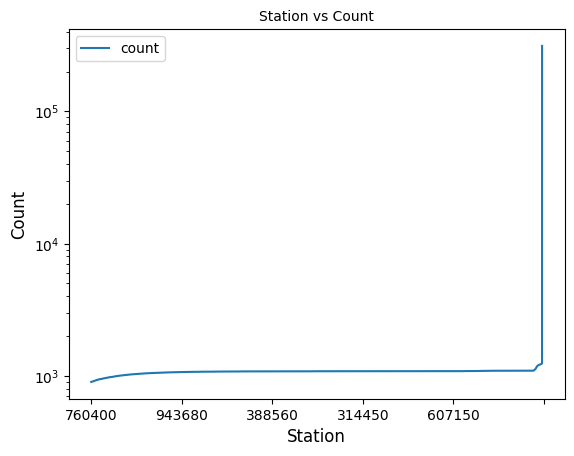

In [ ]:
# plot for stations with good data quality (station vs count)
plt.figure(figsize=(80, 50))
tmp.plot(x='stn',y='count')
plt.xlabel("Station",  size = 12)
plt.ylabel("Count", size = 12)
plt.title("Station vs Count", size = 10)
plt.xticks(ticks = range(6), rotation=45, minor=True)
plt.yscale('log') # used log scale to enhance the plot
plt.show()

## Rolling Averages

In [ ]:
# create date and unix_timestamp columns
gsod = (
    gsod.withColumn('date',F.to_date(F.concat_ws("-", F.col('year'), F.col('mo'), F.col('da')))) # date in yyyy-mm-dd format
        .withColumn('unix_timestamp', F.unix_timestamp('date')) # unix_timestamp
)

gsod.select('year','mo','da','date','unix_timestamp').show()

+----+---+---+----------+--------------+
|year| mo| da|      date|unix_timestamp|
+----+---+---+----------+--------------+
|2018| 04| 21|2018-04-21|    1524268800|
|2018| 06| 07|2018-06-07|    1528329600|
|2018| 03| 12|2018-03-12|    1520812800|
|2018| 01| 08|2018-01-08|    1515369600|
|2018| 05| 05|2018-05-05|    1525478400|
|2018| 01| 27|2018-01-27|    1517011200|
|2018| 02| 11|2018-02-11|    1518307200|
|2018| 01| 28|2018-01-28|    1517097600|
|2018| 01| 28|2018-01-28|    1517097600|
|2018| 11| 16|2018-11-16|    1542326400|
|2018| 01| 09|2018-01-09|    1515456000|
|2018| 04| 07|2018-04-07|    1523059200|
|2018| 01| 04|2018-01-04|    1515024000|
|2018| 02| 13|2018-02-13|    1518480000|
|2018| 01| 13|2018-01-13|    1515801600|
|2018| 01| 12|2018-01-12|    1515715200|
|2018| 09| 27|2018-09-27|    1538006400|
|2018| 10| 12|2018-10-12|    1539302400|
|2018| 02| 22|2018-02-22|    1519257600|
|2018| 02| 02|2018-02-02|    1517529600|
+----+---+---+----------+--------------+
only showing top

let's just use `stn == 406370` for demo purposes.

In [ ]:
# filter the gsod dataset for stn=406370 and order by date
gsod_stn = gsod.filter(F.col('stn')==406370).orderBy('date')

# display the result
gsod_stn.show()

+------+-----+----+---+---+----+----------+----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+--------+----------+--------------+
|   stn| wban|year| mo| da|temp|count_temp|dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust| max|flag_max| min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|      temp_celsius|wdsp_mps|      date|unix_timestamp|
+------+-----+----+---+---+----+----------+----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+--------+----------+--------------+
|406370|99999|2017| 01| 03|47.4|         7|43.2|         7|1023.2| 

Convert this data sample toPandas() and make a nice line plot of `temp` vs. date. Remember to convert the date to a datetime and then set the index as the date column in order to get a nice looking graph.

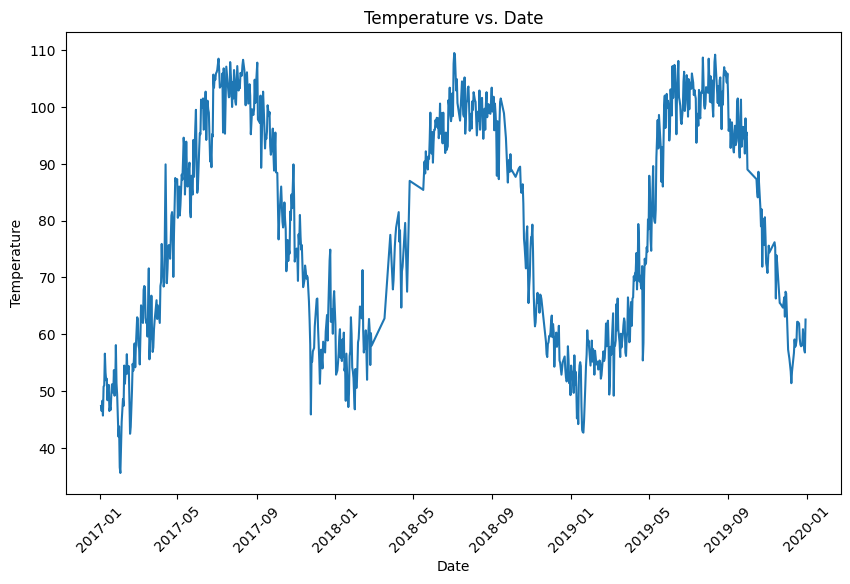

In [ ]:
p_gsod_stn = gsod_stn.select('temp','date').toPandas() # create a pandas dataframe with temp and date columns
p_gsod_stn['date'] = pd.to_datetime(p_gsod_stn['date']) # convert date to datetime type
p_gsod_stn.set_index('date', inplace=True) # set date as index

# plot temp vs date
plt.figure(figsize=(10, 6))
plt.plot(p_gsod_stn.index, p_gsod_stn['temp'], linestyle='-')

# label the axis
plt.xlabel('Date')
plt.ylabel('Temperature')

# give the title
plt.title('Temperature vs. Date')

# rotate the x-axis values to 45 degrees
plt.xticks(rotation=45)

# no grids in the plot
plt.grid(False)

# display the result
plt.show()

Check to make sure there are no missing values in the `temp` column.

In [ ]:
# filter the gsod_stn for null values in temp column
temp_null_count = gsod_stn.filter(F.col('temp').isNull()).count()
print('Missing values count in temp column:',temp_null_count)

Missing values count in temp column: 0


Check out the data quality of April 2018 and show 30 rows for this station. Make a comment about the data quality.

In [ ]:
# filter the gsod_stn for April 2018
gsod_stn = gsod_stn.filter((F.col('year')==2018) & (F.col('mo')==4))

# display the result
gsod_stn.show()

+------+-----+----+---+---+----+----------+----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+------------------+----------+--------------+
|   stn| wban|year| mo| da|temp|count_temp|dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust| max|flag_max| min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|      temp_celsius|          wdsp_mps|      date|unix_timestamp|
+------+-----+----+---+---+----+----------+----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+------------------+----------+--------------+
|406370|99999|2018| 04| 01|69.5|     

**Comments:**

1. The dataset does not have entries/observations for every day in April, indicating gaps in the data.
2. The dataset contains numerous 0s,999.9,9999.9 values in variables like *wdsp,fogprcp,mspsd,gust*, which suggests that a substantial poertion of the data is  missing values. So, the data quality is poor.
3. Columns like *flag max* and *flag min* contains special characters(e.g. '*')  which are typically used to indicate data anomalies or note that the associated value did not meet certain quality criteria.

Create the window function for a 3 day rolling temperature (remember - time matters!) The window should be composed of today, yesterday, and two days ago.



In [ ]:
# import window function
from pyspark.sql.window import Window

# define the number of days to roll over i.e, 3 days
days = 3

# create the window of 3 days
w = Window().orderBy(F.col("unix_timestamp")).rangeBetween(-86400 * (days - 1), 0) # order by unix_timestamp and apply rangebetween function

# take the temp avg for 3 days window and add the new column 'temp_avg_3d' to gsod_stn
gsod_stn = gsod_stn.withColumn('temp_avg_3d', F.avg('temp').over(w))

# display the result
gsod_stn.select('stn','date','temp','temp_avg_3d').show()

+------+----------+----+-----------------+
|   stn|      date|temp|      temp_avg_3d|
+------+----------+----+-----------------+
|406370|2018-04-01|69.5|             69.5|
|406370|2018-04-02|72.4|            70.95|
|406370|2018-04-03|75.5|72.46666666666667|
|406370|2018-04-04|77.4|75.10000000000001|
|406370|2018-04-05|78.8|77.23333333333333|
|406370|2018-04-09|81.5|             81.5|
|406370|2018-04-10|76.3|             78.9|
|406370|2018-04-11|78.3|             78.7|
|406370|2018-04-13|64.7|             71.5|
|406370|2018-04-14|71.1|             67.9|
|406370|2018-04-15|71.9|69.23333333333333|
|406370|2018-04-19|79.6|             79.6|
|406370|2018-04-22|67.5|             67.5|
|406370|2018-04-26|87.0|             87.0|
+------+----------+----+-----------------+



Make a line plot with the raw temperature value (in blue) and the rolling window temperature value (in orange).

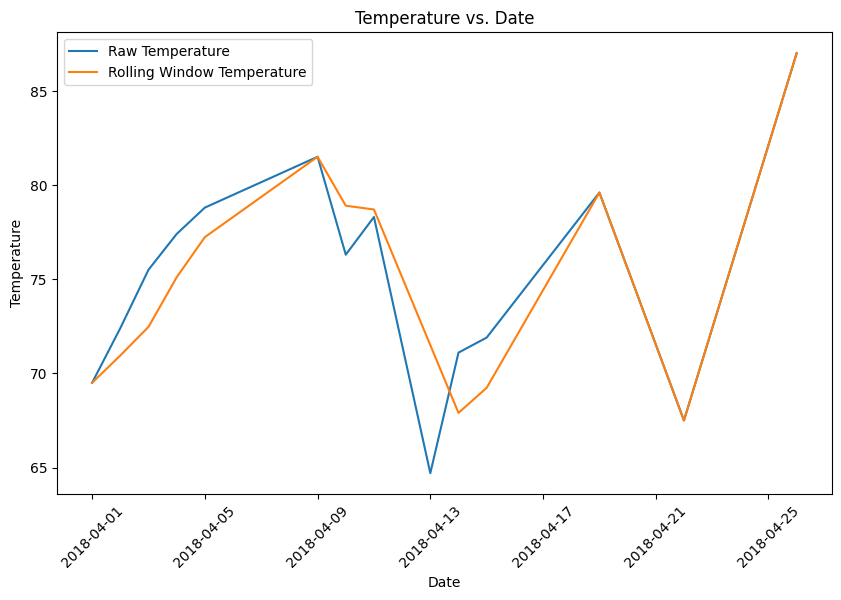

In [ ]:
p_gsod_stn = gsod_stn.select('date', 'temp', 'temp_avg_3d').toPandas() # create a pandas dataframe with date,temp and temp_avg_3d columns
p_gsod_stn['date'] = pd.to_datetime(p_gsod_stn['date']) # convert date to datetime type
p_gsod_stn.set_index('date', inplace=True) # set date as index

# make a single plot of temp vs date and temp_avg_3d vs date
plt.figure(figsize=(10, 6))
plt.plot(p_gsod_stn.index, p_gsod_stn['temp'], linestyle='-', label='Raw Temperature')
plt.plot(p_gsod_stn.index, p_gsod_stn['temp_avg_3d'], linestyle='-', label='Rolling Window Temperature')

# label the plot
plt.xlabel('Date')
plt.ylabel('Temperature')

# set the plot title
plt.title('Temperature vs. Date')

# rotate the x-axis values to 45 degrees
plt.xticks(rotation=45)

# set the plot legends
plt.legend()

# no grid lines in the plot
plt.grid(False)

# display the result
plt.show()

# 🔵  Pandas UDFs and/or Window Functions

## Consecutive Values Above Threshold
I would like a new column in the PySpark DataFrame that contains the maximum consecutive values above a threshold (>=90 degF).

If the raw values are [91, 89, 88, 93, 94, 101, 85], then the output should be [1, 0, 0, 1, 2, 3, 0]. You are summing cumulative logical values!

In [ ]:
# import window
from pyspark.sql.window import Window

gsod_may2018 = (
    gsod.filter((F.col('stn') == 406370) & (F.col('year') == 2018) & (F.col('mo') == '05')) # filter gsod for station=406370 and 2018 may
    .orderBy("date") # order by date
    .withColumn('temp_recoded',F.when(F.col('temp')>90,1).otherwise(0)) # recode the temp values where temp>90 as 1 otherwise 0
    .withColumn("ID", F.monotonically_increasing_id()) # create a new column 'ID' with monotonically increasing integers (i.e,1,2,3..etc)
    .withColumn("group",
                F.row_number().over(Window.orderBy("ID"))- F.row_number().over(Window.partitionBy('temp_recoded').orderBy("ID"))) # create a new column 'group' using row number difference based on 'temp_recoded' partition and ordering by 'ID'
    .withColumn("cum_temp", F.when(F.col('temp_recoded') != 0, F.row_number().over(Window.partitionBy("group").orderBy("ID"))).otherwise(F.lit(0))) # create a new column 'cum_temp' with row numbers partitioned by 'group' and ordered by 'ID', resetting to 0 where 'temp_recoded' is 0
    .orderBy("ID")  # order the DataFrame by 'ID'
    .drop("ID", "group") # drop the columns 'ID', 'group', and 'temp_recoded'
)

# display the result
gsod_may2018.select('stn','date','temp','cum_temp').show()

+------+----------+----+--------+
|   stn|      date|temp|cum_temp|
+------+----------+----+--------+
|406370|2018-05-16|85.5|       0|
|406370|2018-05-17|85.4|       0|
|406370|2018-05-18|88.1|       0|
|406370|2018-05-19|90.4|       1|
|406370|2018-05-20|88.3|       0|
|406370|2018-05-21|92.2|       1|
|406370|2018-05-22|90.0|       0|
|406370|2018-05-23|90.7|       1|
|406370|2018-05-24|89.0|       0|
|406370|2018-05-25|91.3|       1|
|406370|2018-05-26|90.9|       2|
|406370|2018-05-27|94.3|       3|
|406370|2018-05-28|99.0|       4|
|406370|2018-05-29|93.2|       5|
|406370|2018-05-30|91.8|       6|
|406370|2018-05-31|95.6|       7|
+------+----------+----+--------+



Check the answer on May 2018 for Station 406370 visually! Plot raw temperature on one graph (as you see below) and plot cumulative sum above a threshold on another graph. Then visually compare to make sure you solved it correctly.

**CHECK THE WORK!!!**

In [ ]:
p_gsod_may2018 = gsod_may2018.select('date','temp','cum_temp').toPandas() # create a pandas dataframe with columns date,temp,cum_temp
p_gsod_may2018['date'] = pd.to_datetime(p_gsod_may2018['date']) # convert date to datetime
p_gsod_may2018.set_index('date', inplace=True) # set date as index

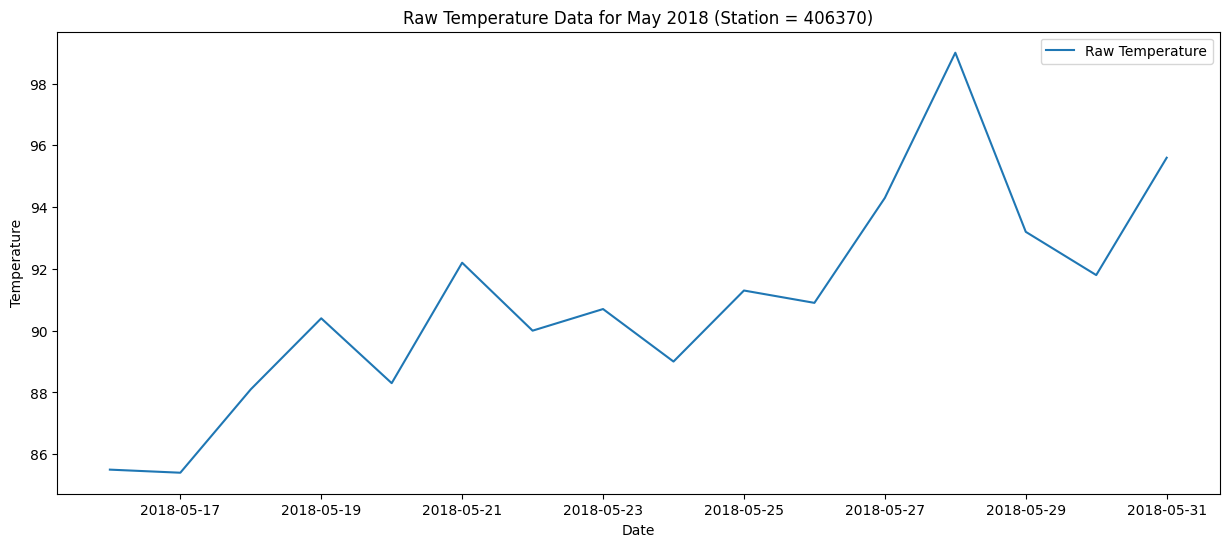

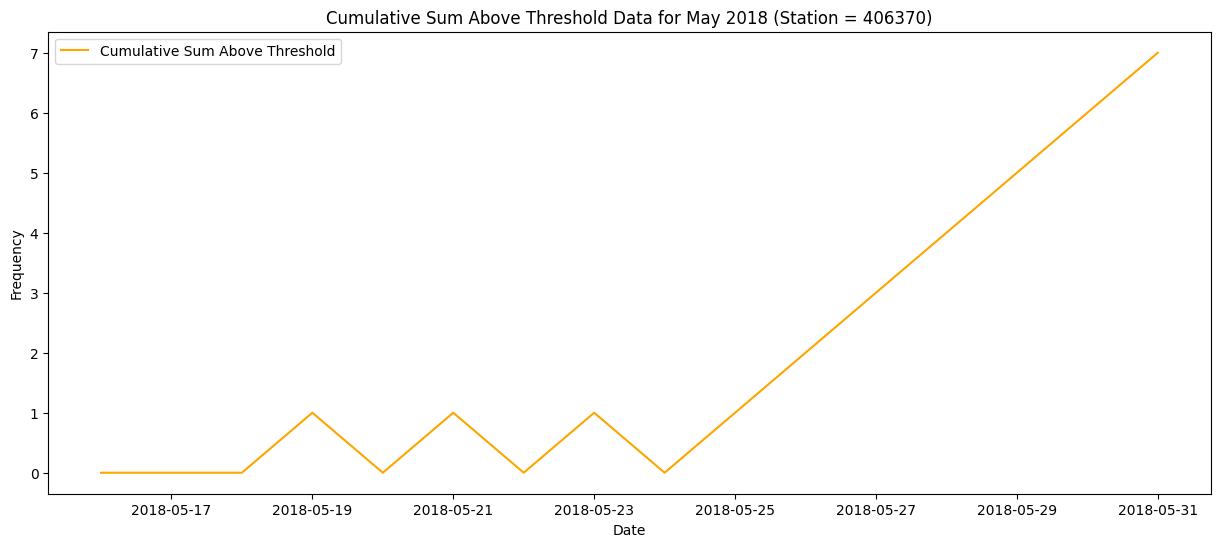

In [ ]:
# plot temp(raw temperatures) vs date for station=406370 in may 2018
plt.figure(figsize=(15, 6))
plt.plot(p_gsod_may2018.index, p_gsod_may2018['temp'], label='Raw Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Raw Temperature Data for May 2018 (Station = 406370)')
plt.legend()
plt.show()

# plot cum_temp vs date for station=406370 in may 2018
plt.figure(figsize=(15, 6))
plt.plot(p_gsod_may2018.index, p_gsod_may2018['cum_temp'], label='Cumulative Sum Above Threshold', color='orange')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Cumulative Sum Above Threshold Data for May 2018 (Station = 406370)')
plt.legend()
plt.show()